In [ ]:
# import sys
# !{sys.executable} -m pip install pygam

## import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, s, te
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

## load dataset

In [2]:
original_dat = pd.read_csv('single_housing.csv')

In [3]:
original_dat

,Street,City,State,Zip,Price,SqFt,Acreage,Beds,Baths,geoadd,Latitude,Longitude,CheckAddDuplicate
0,103 Meadow Side Ct,Carrollton,GA,30116,2249,1436.0,0.42,3.0,2.0,"103 Meadow Side Ct, Carrollton, GA 30116",33.568164,-85.040620,False
1,39 Mountain View Dr,Rockmart,GA,30153,2675,3107.0,0.36,4.0,3.0,"39 Mountain View Dr, Rockmart, GA 30153",34.009622,-85.017519,False
2,32 Mountain View Dr,Rockmart,GA,30153,2099,1276.0,0.35,3.0,2.0,"32 Mountain View Dr, Rockmart, GA 30153",34.008885,-85.018616,False
3,381 Wingfoot St,Rockmart,GA,30153,2190,1447.0,0.33,3.0,2.0,"381 Wingfoot St, Rockmart, GA 30153",34.004158,-85.033841,False
4,30 Standing Rock Rd,Senoia,GA,30276,2200,1728.0,1.03,3.0,2.0,"30 Standing Rock Rd, Senoia, GA 30276",33.305696,-84.558150,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6106,6260 New Mill Trl,Acworth,GA,30102,1975,1300.0,0.69,3.0,2.0,"6260 New Mill Trl, Acworth, GA 30102",34.107751,-84.627044,False
6107,115 Jameson Dr,Acworth,GA,30102,2750,2113.0,0.00,3.0,2.5,"115 Jameson Dr, Acworth, GA 30102",34.114253,-84.637448,False
6108,6340 McCollum Ln,Acworth,GA,30102,5750,1480.0,1.00,4.0,2.0,"6340 McCollum Ln, Acworth, GA 30102",34.104797,-84.638603,False
6109,19 Moonlight Dr,Acworth,GA,30102,5200,1237.0,1.00,3.0,2.5,"19 Moonlight Dr, Acworth, GA 30102",34.111894,-84.659457,False


In [4]:
#create duplicate dataset
dat = original_dat

## data cleaning

<AxesSubplot:xlabel='Price'>

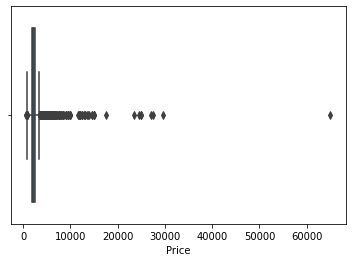

In [5]:
sns.boxplot(data=dat, x='Price')

In [6]:
#remove outliers
percentile25 = dat['Price'].quantile(0.25)
percentile75 = dat['Price'].quantile(0.75)
IQR = percentile75 - percentile25
dat = dat.loc[(dat['Price']>percentile25-1.5*IQR) & (dat['Price']<percentile75+1.5*IQR),]

In [7]:
#number of rows removed
len(original_dat) - len(dat)

527

In [8]:
#remove non-numeric columns
dat = dat.drop(['Street','City','State','Zip','geoadd','CheckAddDuplicate'], axis=1)

In [9]:
dat.describe()

,Price,SqFt,Acreage,Beds,Baths,Latitude,Longitude
count,5584.000000,5436.000000,5584.000000,5564.000000,5583.000000,5584.000000,5584.000000
mean,2137.112643,1782.698389,0.912957,3.192128,2.254164,33.773794,-84.369918
std,444.120790,892.503206,22.728031,0.852781,0.628198,0.215588,0.286286
min,906.000000,100.000000,0.000000,1.000000,0.500000,33.294761,-85.048940
25%,1845.000000,1346.750000,0.000000,3.000000,2.000000,33.606029,-84.570788
50%,2099.000000,1686.500000,0.000000,3.000000,2.000000,33.772935,-84.364104
75%,2399.250000,2126.500000,0.350000,4.000000,2.500000,33.925092,-84.153509
max,3450.000000,49299.440000,1332.000000,8.000000,8.000000,34.365909,-83.782030


In [10]:
dat.isna().sum()

Price          0
SqFt         148
Acreage        0
Beds          20
Baths          1
Latitude       0
Longitude      0
dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Count'>

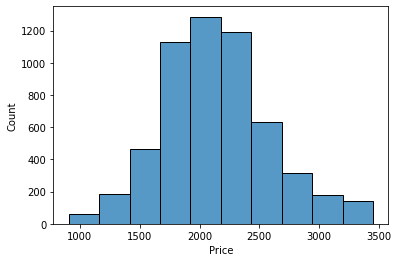

In [11]:
sns.histplot(data=dat, x='Price', bins=10)

## PCA matrix completion

In [ ]:
#fill NAs temporary
dat = dat.fillna(dat.mean())

## linear regression

In [ ]:
#prep the data
# X = dat[['Latitude','Longitude']].values
# X = dat[['SqFt','Acreage','Beds','Baths']].values
X = dat.iloc[: , 1:].values
y = dat['Price'].values

In [ ]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
#fit the model
linear_reg = LinearRegression().fit(X_train, y_train)

In [ ]:
#evaluate the model
test_preds = linear_reg.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, test_preds))

In [ ]:
print('The out-of-sample error: ' + str(round(rmse,3)))

## GAM

In [ ]:
#prep the data
# X = dat[['Latitude','Longitude']].values
# X = dat[['SqFt','Acreage','Beds','Baths']].values
X = dat.iloc[: , 1:].values
y = dat['Price'].values

In [ ]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
#fit the model
# gam_reg = LinearGAM(s(0) + s(1) + te(0,1)).fit(X, y)
gam_reg = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X, y)

In [ ]:
#evaluate the model
test_preds = gam_reg.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, test_preds))

In [ ]:
print('The out-of-sample error: ' + str(round(rmse,3)))

## KNN

In [ ]:
#prep the data
# X = dat[['Latitude','Longitude']].values
X = dat[['SqFt','Acreage','Beds','Baths']].values
# X = dat.iloc[: , 1:].values
y = dat['Price'].values

In [ ]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
#tune the model
outsample = []
k = list(range(1,20)) + list(range(20,100,5)) + list(range(100,501,100))

for i in range(len(k)):
    knn_model = KNeighborsRegressor(n_neighbors=k[i])
    knn_model.fit(X_train, y_train)
    #out-of-sample
    test_preds = knn_model.predict(X_test)
    outsample.append(sqrt(mean_squared_error(y_test, test_preds)))

In [ ]:
knn_dat = pd.DataFrame({'k':k, 'out-of-sample error':outsample})
sns.lineplot(data=knn_dat, x='k', y='out-of-sample error')

In [ ]:
#finalize the model
optimalk = k[outsample.index(min(outsample))]
print('The best k for out-of-sample prediction: ' + str(optimalk))
print('The best out-of-sample error: ' + str(round(min(outsample),3)))

## random forest

In [ ]:
#prep the data
# X = dat[['SqFt','Acreage','Beds','Baths']].values
X = dat.iloc[: , 1:].values
y = dat['Price'].values

In [ ]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [ ]:
#tune the model
maxfeatures = [2,3,4,5,6]
samplesleaf = list(range(1,15)) + list(range(15,50,5))
bestmaxfeature = 99999
bestsamplesleaf = 99999
best_outsample = 99999

for i in tqdm(range(len(maxfeatures))):
    for j in range(len(samplesleaf)):
        rf_model = RandomForestRegressor(n_estimators=1000, 
                                         max_features=maxfeatures[i], 
                                         min_samples_leaf=samplesleaf[j])
        rf_model.fit(X_train, y_train)
        #out-of-sample
        test_preds = rf_model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, test_preds))
        if rmse < best_outsample:
            bestmaxfeature = maxfeatures[i]
            bestsamplesleaf = samplesleaf[j]
            best_outsample = rmse

In [ ]:
print('The best max_features for out-of-sample prediction: ' + str(bestmaxfeature))
print('The best min_samples_leaf for out-of-sample prediction: ' + str(bestsamplesleaf))
print('The best out-of-sample error: ' + str(round(best_outsample,3)))

In [ ]:
#thoughts
#1. PCA matrix completion to fill missing values (currently substituted for column means)
#2. linear_reg, GAM, KNN and rf to predict prices
#3. learn boosting tree (generalized boosting model) and neural network to predict prices
#4. possibly learn support vector regression to predict prices

#aside
#the dataset is raw, probably need to remove the outliers (already done)
#need to add CV measures
#the ultimate goal is to try to make better predictions on price than we did in summer

#final deliverable (a short paper)
#introduction
#table of model performance
#table of model computation time
#plot of best models performance
#explaination of best models